# Calculating SST Bias from FLC Masking

Sections: 
* Functions for creating 11-3.9 BTD from GOES data
* Sample BTD to use as framework throughout
* <font color='red'> Loading the static elements for date </font> (needs updating)
* Finding the FLC index
* <font color='green'> Estimating SST impact using only FLC index (optional) </font>
* Estimating SST impact using FLC index and static elements 

Data to run: 
* ABI data
    * from /mnt/grb/goes16/ on smiller2
    * copied to /home/jturner/false_low_clouds_2023/Static_Features/ on jpss-cloud4
* FLC index data
    * from NOAA AVHRR portal (SST) and NOAA GFS portal (temperature and moisture)
    * stored at /home/jturner/false_low_clouds_2023/Model/Time_Lapse/time_00z/ on jpss-cloud4

In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from sklearn.preprocessing import normalize
import fnmatch
import pickle
import timeit
import pandas as pd
import goes_grid_convert as ggc

In [2]:
date = "20220523"

root = "/home/jturner/false_low_clouds_2023/Static_Features/"+date

path = "/home/jturner/false_low_clouds_2023/Static_Features/estimation_data"

In [3]:
#---CONUS
# region = "conus"
# min_lon = -126
# min_lat = 24.5
# max_lon = -64
# max_lat = 49.5

#---Georges Bank
region = "georgesbank"
min_lon = -71.5
min_lat = 37
max_lon = -64
max_lat = 42.5

#---Gulf Stream
# region = "gulfstream"
# min_lon = -83
# min_lat = 26
# max_lon = -51
# max_lat = 50



## Sample BTD to use as a framework throughout

In [4]:
data_07 = xr.open_dataset('/home/jturner/false_low_clouds_2023/Static_Features/sample_data/OR_ABI-L1b-RadF-M6C07_G16_s20222570500207_e20222570509526_c20222570509568.nc')
data_14 = xr.open_dataset('/home/jturner/false_low_clouds_2023/Static_Features/sample_data/OR_ABI-L1b-RadF-M6C14_G16_s20222570500207_e20222570509515_c20222570509597.nc')

ds_07 = ggc.calc_latlon(data_07)
ds_14 = ggc.calc_latlon(data_14)

lats = (min_lat, max_lat)
lons = (min_lon, max_lon)

((x1,x2), (y1, y2)) = ggc.get_xy_from_latlon(ds_07, lats, lons)

subset_07 = ds_07.sel(x=slice(x1, x2), y=slice(y2, y1))
subset_14 = ds_14.sel(x=slice(x1, x2), y=slice(y2, y1))

T_07 = (subset_07.planck_fk2/(np.log((subset_07.planck_fk1/subset_07.Rad)+1)) - subset_07.planck_bc1)/subset_07.planck_bc2
T_14 = (subset_14.planck_fk2/(np.log((subset_14.planck_fk1/subset_14.Rad)+1)) - subset_14.planck_bc1)/subset_14.planck_bc2

BTD = T_14 - T_07

## Loading the Static Elements for the date

In [5]:
file = open(path+"/"+date+"_static_elements_"+region, 'rb')
BTD = pickle.load(file)
file.close()

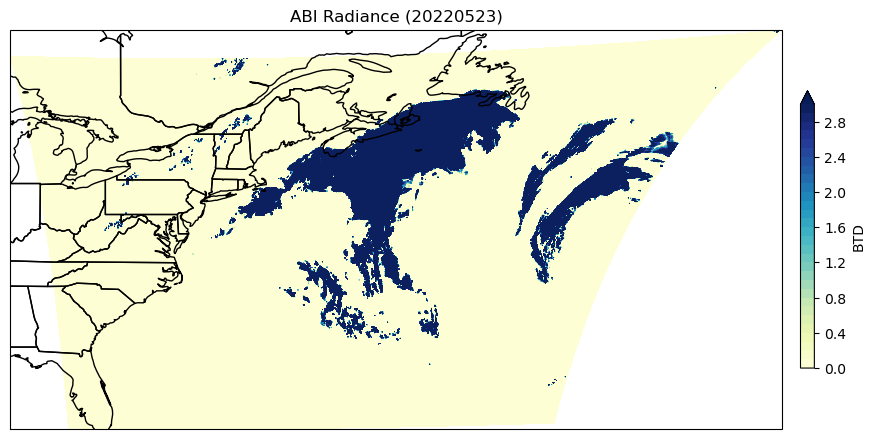

In [6]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlGnBu
#levels = np.linspace(np.amin(BTD), np.amax(BTD), 31)
levels = np.linspace(0, 3, 31)

c=ax.contourf(subset_07.Rad.lon, subset_07.Rad.lat, BTD, cmap=cmap, levels=levels, extend='max')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('ABI Radiance ('+date+')')
clb.set_label('BTD')

ax.add_feature(cfeature.STATES)

## Finding the FLC index
* time set to 00z
* temperature difference normalized between -4 and 4
* specific humidity normalized between 0 and 0.016

In [7]:
time = "00z"

index_root = "/home/jturner/false_low_clouds_2023/Model/Time_Lapse/time_"+time+"/"

In [8]:
sst_file = index_root+date+"/oisst-avhrr-v02r01."+date+".nc"

sst_ds = xr.open_dataset(sst_file)
sst_ds =  sst_ds.squeeze()
sst_ds.sst.values = sst_ds.sst.values+273.15

In [9]:
#--- Adjustment for 360 degree longitudes

max_lon_360 = max_lon + 360
min_lon_360 = min_lon + 360

In [10]:
t = xr.open_dataset(index_root+date+'/t_'+date+'.nc')
q = xr.open_dataset(index_root+date+'/q_'+date+'.nc')

In [11]:
sst_ds = sst_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon_360,max_lon_360))
t = t.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon_360,max_lon_360))
q = q.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon_360,max_lon_360))

In [12]:
begin = sst_ds.sst.shape[0]
end = sst_ds.sst.shape[1]

dims = t.t[0:begin,0:end]

diff = t.t[0:begin,0:end].values - sst_ds.sst[:,:].values

In [13]:
bottom_lim = -4

diff_np = np.asarray(diff).copy()
under_lim = diff_np < bottom_lim
diff_np[under_lim] = bottom_lim

In [14]:
top_T = 4

diff_norm = diff_np/(top_T - bottom_lim)

In [15]:
top_q = 0.016
bottom_q = 0.000
q_norm = (q.q[0:begin,0:end].values)/(top_q - bottom_q)
q_norm_av = (q.q[0:begin,0:end].values)/(top_q - bottom_q)

In [16]:
flc_index = diff_norm*q_norm

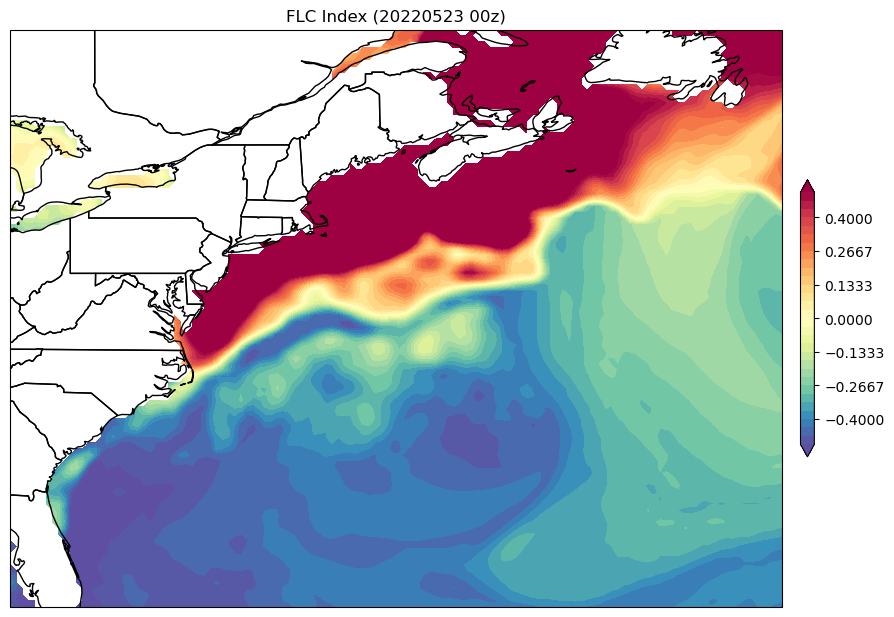

In [17]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(-0.5, 0.5, 31)

c=ax.contourf(dims.longitude, dims.latitude, flc_index, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('FLC Index ('+date+' '+ time+')')
clb.set_label('')

ax.add_feature(cfeature.STATES)

## <font color='green'>Estimating SST impact using only FLC index</font>
* masked when FLC index > 0.15

In [ ]:
row_meshgrid, col_meshgrid = np.meshgrid(dims.latitude, dims.longitude, indexing='ij')

flc_xr = xr.Dataset(
    data_vars=dict(
        flc_index=(["x","y"], flc_index)
    ),
    coords=dict(
        latitude=(["x","y"], row_meshgrid),
        longitude=(["x","y"], col_meshgrid),
    ),
    attrs=dict(description="FLC index in the designated region"),
)

In [ ]:
flc_above = flc_xr.where(flc_xr.flc_index > 0.15)

In [ ]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.cool
levels = np.linspace(0, np.amax(flc_above.flc_index), 21)

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(flc_above.longitude[0,:], flc_above.latitude[:,0], flc_above.flc_index, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Total FLC Index > 0.15')
clb.set_label('Total FLC')

In [ ]:
flat_flc_above = np.array(flc_above.flc_index).flatten()
flat_flc_above = flat_flc_above[~np.isnan(flat_flc_above)]
print(len(flat_flc_above))

In [ ]:
sum_sst_masked = 0
count_masked = 0

for j in range(flc_index.shape[1]):  # Loop over columns
    for i in range(flc_index.shape[0]):  # Loop over rows
        if flc_index[i][j] > 0.15:
            #print(i, j, float(dims.longitude[j].values), float(dims.latitude[i].values), "flc index", flc_index[i][j], "sst", sst_ds.sst[i][j].values)
            sum_sst_masked += sst_ds.sst[i][j].values
            count_masked += 1

#--- Flattened the 2d array in order to remove nans more easily            
flat_sst = np.array(sst_ds.sst).flatten()
flat_sst = flat_sst[~np.isnan(flat_sst)]

print("total masked sst:", sum_sst_masked)
print("total filled in sst:", np.sum(flat_sst))
print("number of masked points:", count_masked)
print("number of filled in points:", len(flat_sst))
print("average of masked:", sum_sst_masked/count_masked)
print("average sst filled in:", np.mean(flat_sst))
average_sst_masked = (np.sum(flat_sst) - sum_sst_masked) / (len(flat_sst)-count_masked)
print("average sst with flc mask:", average_sst_masked)
print("bias caused by flc masking:", average_sst_masked - np.mean(flat_sst))

## Estimating SST impact using FLC index and Static Elements
* creates xarray datasets for the FLC index and Static Elements
* for each FLC index point, if FLC index > 0.15 and nearest Static Elements point is > 0.5, it is masked
* bias is difference between average SST and average SST with masked points removed

In [18]:
row_meshgrid, col_meshgrid = np.meshgrid(dims.latitude, dims.longitude, indexing='ij')

flc_xr = xr.Dataset(
    data_vars=dict(
        flc_index=(["x","y"], flc_index)
    ),
    coords=dict(
        latitude=(["x","y"], row_meshgrid),
        longitude=(["x","y"], col_meshgrid),
    ),
    attrs=dict(description="FLC index in the designated region"),
)

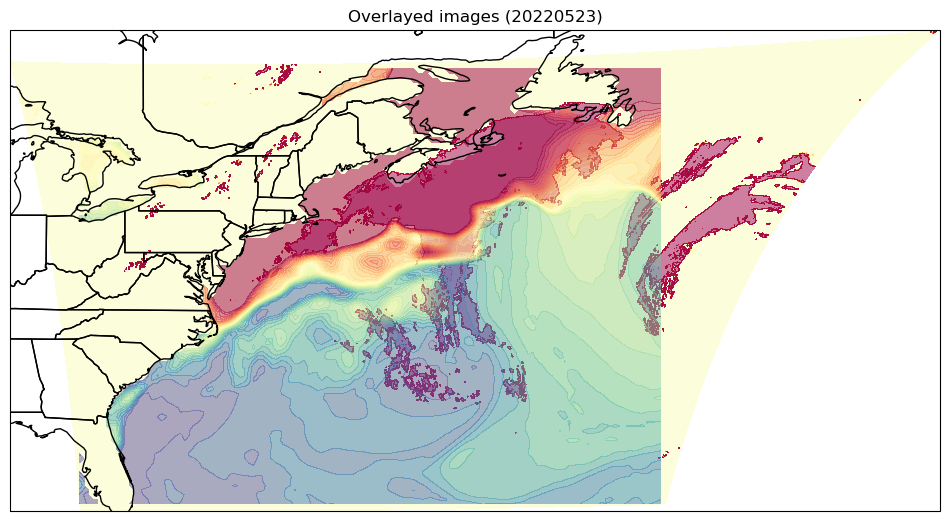

In [19]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(-0.5, 0.5, 31)

ax.contourf(subset_07.Rad.lon, subset_07.Rad.lat, BTD, cmap=cmap, levels=levels, extend='max', alpha=0.5)
ax.contourf(flc_xr.longitude, flc_xr.latitude, flc_xr.flc_index, cmap=cmap, levels=levels, extend='both', alpha=0.5)

ax.set_title('Overlayed images ('+date+')')

ax.add_feature(cfeature.STATES)

In [20]:
btd_ds = xr.Dataset({'BTD':(('x', 'y'),BTD)},
                    coords = {'latitude': (('x', 'y'), subset_07.Rad.lat.values),
                              'longitude': (('x', 'y'), subset_07.Rad.lon.values)},
                    attrs={'variable':'Brightness Temperature Difference'})
btd_ds

<xarray.Dataset>
Dimensions:    (x: 928, y: 1513)
Coordinates:
    latitude   (x, y) float32 50.147675 50.146793 ... 25.999338 26.000082
    longitude  (x, y) float32 -86.79306 -86.761894 ... -51.028435 -51.00484
Dimensions without coordinates: x, y
Data variables:
    BTD        (x, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    variable:  Brightness Temperature Difference

In [21]:
sum_sst_masked = 0
count_masked = 0

masked_sst_df = pd.DataFrame(columns=['Latitude', 'Longitude', 'SST'])

starttime = timeit.default_timer()

for j in range(flc_index.shape[1]):  # Loop over columns
    for i in range(flc_index.shape[0]):  # Loop over rows
        if flc_index[i][j] > 0.15:
            
            lon = float(dims.longitude[j].values)-360
            lat = float(dims.latitude[i].values)
            
            #--- May replace this brute force method with Matt's interpolation code
            
            # First, find the index of the grid point nearest a specific lat/lon
            abslat = np.abs(btd_ds.latitude-lat)
            abslon = np.abs(btd_ds.longitude-lon)
            c = np.maximum(abslon, abslat)
            
            #--- Edge case were there are two nearest points
            #--- previous version: ([xloc], [yloc]) = np.where(c == np.min(c))
            location = [np.where(c == np.min(c))[0][0]],[np.where(c == np.min(c))[1][0]]
            ([xloc], [yloc]) = location

            #--- Point in BTD that is closest to the flc index
            
            # Now I can use that index location to get the values at the x/y diminsion
            point_ds = btd_ds.sel(x=xloc, y=yloc)
            
            
            if point_ds.BTD.values > 0.5:
                sum_sst_masked += sst_ds.sst[i][j].values
                count_masked += 1
                
                masked_sst_df = masked_sst_df.append({'Latitude': lat, 'Longitude': lon, 'SST': sst_ds.sst[i][j].values}, ignore_index=True)
                
            
print("Time to colocate data :", timeit.default_timer() - starttime)

Time to colocate data : 64.45456334762275


In [22]:
#--- Analysis of SST bias           
flat_sst = np.array(sst_ds.sst).flatten()
flat_sst = flat_sst[~np.isnan(flat_sst)]

print("number of masked points:", count_masked)
print("number of filled in points:", len(flat_sst))
print("average of masked:", sum_sst_masked/count_masked)
print("average sst filled in:", np.mean(flat_sst))
average_sst_masked = (np.sum(flat_sst) - sum_sst_masked) / (len(flat_sst)-count_masked)
print("bias caused by flc masking:", average_sst_masked - np.mean(flat_sst))

number of masked points: 813
number of filled in points: 8849
average of masked: 281.90513503859404
average sst filled in: 292.87354
bias caused by flc masking: 1.1096810226478624


Text(0.5, 1.0, 'Masked Sea Surface Temperatures (20220523)')

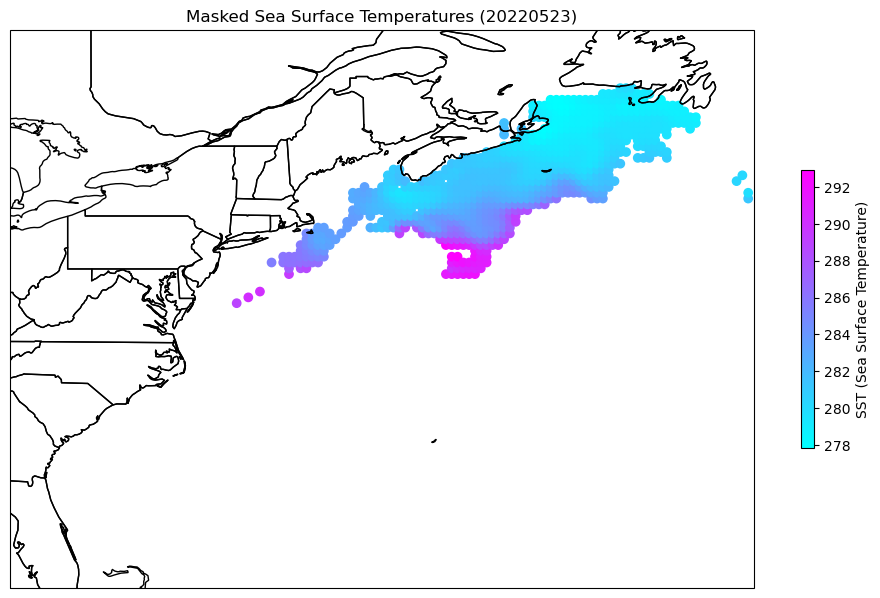

In [23]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.cool
levels = np.linspace(-0.5, 0.5, 31)

sc = ax.scatter(masked_sst_df.Longitude, masked_sst_df.Latitude, c=masked_sst_df.SST, cmap=cmap)

ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES)
ax.coastlines(resolution='50m', color='black', linewidth=1)

cbar = plt.colorbar(sc, ax=ax, cmap=cmap, shrink=0.3)
cbar.set_label('SST (Sea Surface Temperature)')

ax.set_title('Masked Sea Surface Temperatures ('+date+')')